# Multi-layer Perceptron

The implementation of a multi-layer perceptron for the purposes of sentiment analysis. 

## Authors
- Matthew Freestone
- Will Humphlett
- Matthew Shipplet

## Notebook Setup
Configures the notebook, assumes you are using the base conda environment

In [1]:
%load_ext autoreload
%autoreload 2

from src.bootstrap import setup

setup()
    
print("Notebook setup has completed")

Notebook setup has completed


## Environment Setup
Downloads configured dataset and performs necessary environment bootstrapping

In [2]:
from src.bootstrap import *

# other datasets available in src.bootstrap
DATASETS = [CDS_AND_VINYL_JSON_PARAMS, CELL_PHONE_JSON_PARAMS , KINDLE_STORE_JSON_PARAMS, SPORTS_JSON_PARAMS]

for dataset in DATASETS:
    download_data_file(dataset['file'])

File /home/whumphlett/personal/ML-Project/data/CDs_and_Vinyl_5.json.gz already exists, skipping download
File /home/whumphlett/personal/ML-Project/data/Cell_Phones_and_Accessories_5.json.gz already exists, skipping download
File /home/whumphlett/personal/ML-Project/data/Kindle_Store_5.json.gz already exists, skipping download
File /home/whumphlett/personal/ML-Project/data/Sports_and_Outdoors_5.json.gz already exists, skipping download


## Preprocessing
Sanitize data to prepare for feature extraction

In [3]:
from src.preprocessing import get_dataframe

df = get_dataframe(DATASETS, equalize=True)

## Feature Extraction
Convert the dataset into a usable format

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from src.preprocessing import get_subsets

word_vectorizer = CountVectorizer(
    min_df=0.0001, 
    max_df=0.7
)

X = word_vectorizer.fit_transform(df["reviewText"].to_numpy())

# optional, convert a 5 class problem into a 3 class problem
df['overall'].replace(2, 1, inplace=True)
df['overall'].replace(4, 5, inplace=True)

y = df['overall'].to_numpy()

X_train, X_val, X_test, y_train, y_val, y_test = get_subsets(X,y, train_split=0.8, val_split=0.1, test_split=0.1)

## Implementation
Full implementation of our Multi-layer Perceptron

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import List, Sequence, Tuple
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import sparse
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered in exp")


def sigmoid(X: np.ndarray) -> np.ndarray:
    """Sigmoid function"""
    return 1.0 / (1.0 + np.exp(-X))


def dSigmoid(X: np.ndarray) -> np.ndarray:
    """Derivative of sigmoid function"""
    a = 1.0 / (1.0 + np.exp(-X))
    return a * (1 - a)


def tanh(X: np.ndarray) -> np.ndarray:
    """Tanh function"""
    return np.tanh(X)


def dTanh(X: np.ndarray) -> np.ndarray:
    """Derivative of tanh function"""
    return 1.0 - np.tanh(X) ** 2


def relu(X: np.ndarray) -> np.ndarray:
    """Rectified linear unit function"""
    return np.maximum(0, X)


def dRelu(X: np.ndarray) -> np.ndarray:
    """Derivative of rectified linear unit function"""
    return np.where(X > 0, 1, 0)


def softmax(X: np.ndarray) -> np.ndarray:
    """Softmax"""
    tmp = X - X.max(axis=1)[:, np.newaxis]
    return np.exp(tmp) / np.exp(tmp).sum(axis=1)[:, np.newaxis]


def squared_loss(y_true: np.ndarray, y_pred: np.ndarray):
    """Mean squared loss"""
    return ((y_true - y_pred) ** 2).mean() / 2


def L1_reg_loss(weights: List[np.ndarray]) -> float:
    """Lasso regression"""
    c = 0
    for w in weights:
        c += np.sum(np.abs(w))
    return c


def L1_reg_grad(weights: List[np.ndarray]) -> List[np.ndarray]:
    """Lasso regression grad"""
    grad = []
    for w in weights:
        grad.append(np.where(w > 0, 1, -1))
    return grad


def L2_reg_loss(weights: List[np.ndarray]) -> float:
    """Ridge regression"""
    c = 0
    for w in weights:
        w = w.ravel()
        c += np.dot(w, w)
    return c


def L2_reg_grad(weights: List[np.ndarray]) -> List[np.ndarray]:
    """Ridge regression grad"""
    return [2 * w for w in weights]


class MultiLayerPerceptron:
    def __init__(
        self,
        epochs: int,
        lr: float,
        hidden_layers: Sequence[int],
        regularization: str = None,
        reg_const: float = 0.0,
        activation: str = "sigmoid",
    ):
        """An implementation of a multi-layer perceptron with backpropagation

        :param epochs: Number of epochs
        :param lr: Learning rate
        :param hidden_layers: Sequence of integers representing the number of neurons in each hidden layer
        :param regularization: Regularization function, ["l1", "l2"]
        :param reg_const: Regularization constant
        :param activation: Activation function, ["sigmoid", "tanh", "relu"], default="sigmoid"
        """
        self.num_epochs = epochs
        self.lr = lr
        self.regularization = regularization
        self.reg_const = reg_const
        self.hidden_layers = hidden_layers
        self.output_layer = None
        self.input_layer = None
        self._num_layers = len(self.hidden_layers) + 2
        self._yencoder = LabelBinarizer()

        self._output_activation = None

        if activation == "sigmoid" or activation == "logistic":
            self.activation = sigmoid
            self.dActivation = dSigmoid
        elif activation == "tanh":
            self.activation = tanh
            self.dActivation = dTanh
        elif activation == "relu":
            self.activation = relu
            self.dActivation = dRelu
        else:
            raise ValueError("Invalid activation function")

        if regularization is None:
            pass
        elif regularization.lower() == "l1":
            self._loss_reg = L1_reg_loss
            self._grad_reg = L1_reg_grad
        elif regularization.lower() == "l2":
            self._loss_reg = L2_reg_loss
            self._grad_reg = L2_reg_grad
        else:
            raise ValueError("Invalid regularization function")

        self._loss_function = squared_loss
        self._biases = None
        self._weights = None
        self.train_loss_curve = []
        self.val_loss_curve = []

    def epochs(self):
        for i in range(self.num_epochs):
            yield i, self.lr

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        X_val: np.ndarray = None,
        y_val: np.ndarray = None,
        batch_size: int = 1,
        continue_fit=False,
        output=True,
    ) -> None:
        """Fits the model to given data

        :param X: Input data of shape (n_examples, n_features)
        :param y: Output data of shape (n_examples, )
        :param X_val: Validation input data of shape (n_examples, n_features)
        :param y_val: Validation output data of shape (n_examples, )
        :param batch_size: Size of the batch to be used for training, default=1
        :param continue_fit: Continue training from last epoch, default=False
        :param output: Display a progress bar of model fitting, default=True
        :return: None
        """
        if len(X.shape) != 2:
            raise ValueError("Invalid shape for X")
        if len(y.shape) != 1:
            raise ValueError("Invalid shape for y")
        n_examples, n_features = X.shape

        use_val = False
        if X_val is not None and y_val is not None:
            use_val = True
            if len(X_val.shape) != 2:
                raise ValueError("Invalid shape for X_val")
            if len(y_val.shape) != 1:
                raise ValueError("Invalid shape for y_val")
        y_combined = np.concatenate((y, y_val)) if use_val else y
        y_combined = self._format_labels(y_combined)
        y, y_val = np.split(y_combined, [n_examples]) if use_val else (y_combined, None)

        if not continue_fit:
            self.input_layer = n_features
            self.output_layer = y.shape[1]
            self._structure = (self.input_layer, *self.hidden_layers, self.output_layer)

            self._biases = [np.random.randn(y, 1) for y in self._structure[1:]]
            self._weights = [np.random.randn(x, y) for x, y in zip(self._structure[:-1], self._structure[1:])]

        epochs = tqdm(self.epochs(), total=self.num_epochs) if output else self.epochs()

        for epoch_num, lr in epochs:
            train_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i : i + batch_size]
                y_batch = y[i : i + batch_size]
                dJdB, dJdW, c_loss = self._backprop(X_batch, y_batch)
                train_loss += c_loss

                self._biases = [b - lr * db for b, db in zip(self._biases, dJdB)]
                self._weights = [w - lr * dw for w, dw in zip(self._weights, dJdW)]
            num_batches = X.shape[0] // batch_size
            self.train_loss_curve.append(train_loss / num_batches)
            if use_val:
                val_loss = self._calc_loss(y_val, self._fast_forward_pass(X_val))
                self.val_loss_curve.append(val_loss)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predicts the output for the given input

        :param X: Input data of shape (n_examples, n_features)
        :return: Output data of shape (n_examples, )
        """
        curr = self._fast_forward_pass(X)
        if self.output_layer == 1:
            curr = curr.ravel()
        return self._yencoder.inverse_transform(curr)

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """Returns the accuracy of the model on the given data

        :param X: Input data of shape (n_examples, n_features)
        :param y: Output data of shape (n_examples, )
        :return: Accuracy score
        """
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def plot_loss(self) -> None:
        """The loss over epochs plot

        :return: None
        """
        plt.plot(self.train_loss_curve, label="Training loss")
        if self.val_loss_curve and len(self.val_loss_curve) == len(self.train_loss_curve):
            plt.plot(self.val_loss_curve, label="Validation loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch")
        plt.legend()
        plt.show()

    def _format_labels(self, y: np.ndarray) -> np.ndarray:
        if len(y.shape) == 2 and y.shape[1] == 1:
            y = y.ravel()
        elif len(y.shape) == 2 and y.shape[1] > 1 or len(y.shape) > 2:
            raise ValueError("Invalid shape for y")

        self._yencoder.fit(y)
        if len(self._yencoder.classes_) == 2:
            self._output_activation = sigmoid
        else:
            self._output_activation = softmax
        return self._yencoder.transform(y)

    def _backprop(self, X: np.ndarray, y: np.ndarray) -> Tuple[List[np.ndarray], List[np.ndarray], float]:
        # initialize empty lists to store the gradient of the biases and weights
        dBias = [np.zeros(b.shape) for b in self._biases]
        dWeights = [np.zeros(w.shape) for w in self._weights]
        n_samples = X.shape[0]

        # do a forward pass to get the activations and z values
        layer_raw = []  # stores the weighted sum of inputs for each layer
        layer_activations = []  # stores the output of each layer
        a = X  # input layer
        for i, (b, W) in enumerate(zip(self._biases, self._weights)):
            # compute the weighted sum of inputs for this layer
            z = a @ W + b.T

            # apply the activation function to the output of this layer
            if i < self._num_layers - 2:
                a = self.activation(z)
            else:
                a = self._output_activation(z)
            # store the raw output and the activated output of this layer
            layer_raw.append(z)
            layer_activations.append(a)

        # calculate the loss
        loss = self._calc_loss(y, a)

        # index of the last hidden layer
        last_hidden = self._num_layers - 2

        # compute the error at the last hidden layer
        delta = layer_activations[last_hidden] - y

        # compute the gradient of the biases and weights for the last hidden layer
        dBias[last_hidden] = np.mean(delta, axis=0)
        dWeights[last_hidden] = layer_activations[last_hidden - 1].T @ delta

        # for all hidden layers except the first and last,
        # compute the gradient of the biases and weights
        for L in range(last_hidden - 1, 0, -1):
            # compute the error at this layer
            delta = (delta @ self._weights[L + 1].T) * self.dActivation(layer_raw[L])

            # compute the gradient of the biases and weights for this layer
            dBias[L] = np.mean(delta, axis=0)
            dWeights[L] = layer_activations[L - 1].T @ delta

        # for the input layer, compute the gradient of the biases and weights
        # using the inputs, rather than the previous layer
        delta = (delta @ self._weights[1].T) * self.dActivation(layer_raw[0])
        dBias[0] = np.mean(delta, axis=0)
        dWeights[0] = X.T @ delta

        # add a second dimension to the bias gradient to make it compatible with the bias shape
        dBias = [db[:, np.newaxis] for db in dBias]
        # divide by number of samples to get the average gradient
        dWeights = [dw / n_samples for dw in dWeights]

        # apply regularization if enabled
        if self.regularization:
            dWeights = [dw + self.reg_const * r for dw, r in zip(dWeights, self._grad_reg(self._weights))]
        return dBias, dWeights, loss

    def _calc_loss(self, y_pred: np.ndarray, y_batch: np.ndarray) -> float:
        loss = self._loss_function(y_pred, y_batch)
        if self.regularization:
            loss += (0.5 * self.reg_const) * self._loss_reg(self._weights) / y_pred.shape[0]
        return loss

    def _fast_forward_pass(self, X: np.ndarray) -> np.ndarray:
        curr = X
        for i in range(self._num_layers - 1):
            curr = curr @ self._weights[i]
            curr += self._biases[i].T
            if i < self._num_layers - 2:
                curr = self.activation(curr)
            else:
                curr = self._output_activation(curr)
        return curr

## Two Dimension Problem
Prove that our implemenation of an MLP can learn non-linear decision planes

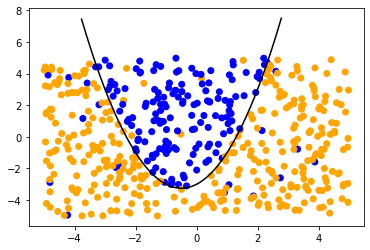

In [6]:
from src.two_dim_problem import TwoDimProblem

problem = TwoDimProblem(5)
X, y = problem.create_data(2, 0.05, 500)
problem.plot_data(show_seperator=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy = 0.898


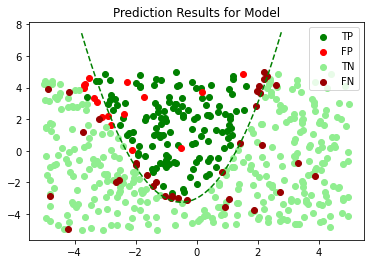

In [7]:
mlp = MultiLayerPerceptron(epochs=50, lr=0.2, hidden_layers=(10, 5))
mlp.fit(X, y)
problem.plot_pred(mlp.predict(X))

## Training
Determine optimal hyperparamters given our problem

In [ ]:
from src.training import matrix_train

# each axis must be an iterable. if you want to use a constant, wrap it in an iterable of len 1
hyperparameter_matrix = {
    "epochs": np.logspace(np.log10(10), np.log10(100), num=5, dtype="int64"),
    "lr": np.logspace(np.log10(.00002), np.log10(.2), num=5),
    "hidden_layers": [[50, 20]],
    "activation": ["sigmoid", "tanh", "relu"],
    "regularization": ["L2", "L1"],
    "reg_const": [0.0001, 0.001],
}

# look at data/train.log for progress

best_params = matrix_train(hyperparameter_matrix, MultiLayerPerceptron, X_train, y_train, X_test, y_test)

print(best_params)
# mlp = MultiLayerPerceptron(**best_params)

In [8]:
# saved for convenience
best_params = {
    "epochs": 20, "lr": .2, "hidden_layers": [50, 20], "activation": "sigmoid", "regularization": "L2", "reg_const": .0001
}

mlp = MultiLayerPerceptron(**best_params)
mlp.fit(X_train, y_train, X_val, y_val, batch_size=200)

  0%|          | 0/20 [00:00<?, ?it/s]

## Performance
Detailed performance report of our mlp

              precision    recall  f1-score   support

           1    0.66424   0.93157   0.77551     50182
           3    0.51231   0.21433   0.30222     25041
           5    0.84367   0.74860   0.79330     49968

    accuracy                        0.71508    125191
   macro avg    0.67341   0.63150   0.62368    125191
weighted avg    0.70547   0.71508   0.68794    125191



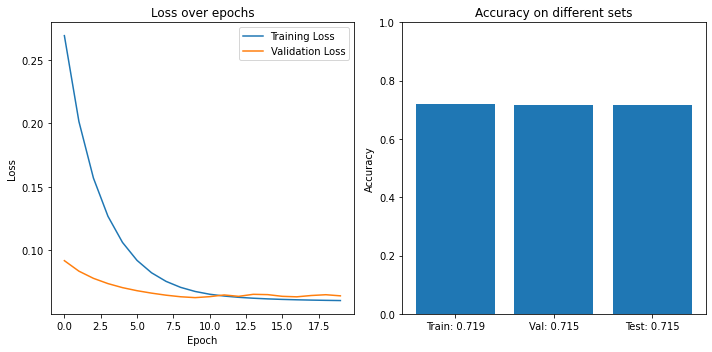

In [9]:
from src.analysis import accuracy, confusion, report, plots

print(report(mlp.predict(X_test), y_test))

plots(mlp.score(X_train, y_train), mlp.score(X_test, y_test), mlp.score(X_val, y_val), mlp.train_loss_curve, mlp.val_loss_curve)

## Benchmarking

### SKLearn Multi-Layer Perceptron

In [10]:
from sklearn.neural_network import MLPClassifier

skl_mlp = MLPClassifier(
    early_stopping=True,
)
skl_mlp = skl_mlp.fit(X_train, y_train)

              precision    recall  f1-score   support

           1    0.77951   0.83877   0.80805     50182
           3    0.50768   0.34587   0.41144     25041
           5    0.79017   0.85605   0.82179     49968

    accuracy                        0.74707    125191
   macro avg    0.69245   0.68023   0.68043    125191
weighted avg    0.72939   0.74707   0.73420    125191



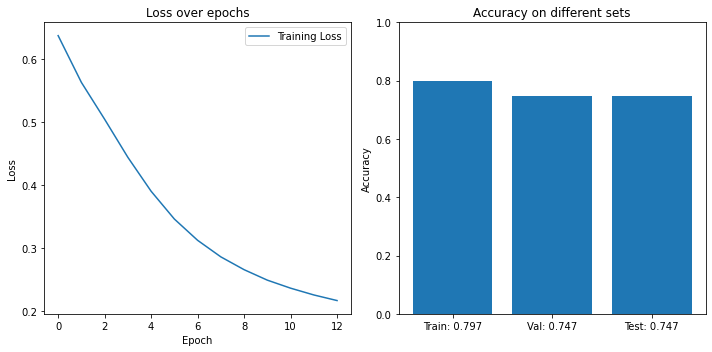

In [11]:
print(report(skl_mlp.predict(X_test), y_test))

plots(skl_mlp.score(X_train, y_train), skl_mlp.score(X_test, y_test), skl_mlp.score(X_val, y_val), skl_mlp.loss_curve_)

### SKLearn Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=200)

              precision    recall  f1-score   support

           1    0.60051   0.74439   0.66476     50182
           3    1.00000   0.00004   0.00008     25041
           5    0.60726   0.76545   0.67724     49968

    accuracy                        0.60391    125191
   macro avg    0.73592   0.50329   0.44736    125191
weighted avg    0.68311   0.60391   0.53679    125191



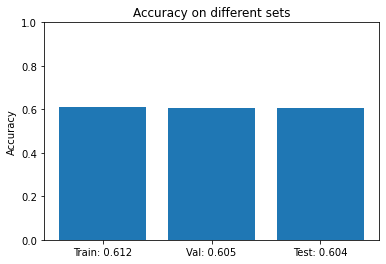

In [13]:
print(report(rf.predict(X_test), y_test))

plots(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.score(X_val, y_val))

### Tensorflow

In [25]:
import tensorflow as tf

# clear tensoflow backend
tf.keras.backend.clear_session()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy", "mse", "mae"]
)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Tensorflow does not accept data in the sparse representation, we must convert it to a dense representation. We also need to convert the labels to one-hot encoding.
However, the dataset is too large to fit in memory as a dense representation, so we will only use a subset of the data.

In [23]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np
SIZE = 10_000
TRAIN_SIZE_RATIO = 0.8
VAL_SIZE_RATIO = 0.1
TEST_SIZE_RATIO = 0.1

keras_y_encoder = LabelBinarizer()

keras_X_train = np.concatenate((X_train[y_train == 1][:int(SIZE*TRAIN_SIZE_RATIO)].toarray(), X_train[y_train == 3][:int(SIZE*TRAIN_SIZE_RATIO)].toarray(), X_train[y_train == 5][:int(SIZE*TRAIN_SIZE_RATIO)].toarray()))
keras_y_train = np.concatenate((y_train[y_train == 1][:int(SIZE*TRAIN_SIZE_RATIO)], y_train[y_train == 3][:int(SIZE*TRAIN_SIZE_RATIO)], y_train[y_train == 5][:int(SIZE*TRAIN_SIZE_RATIO)]))
keras_y_train = keras_y_encoder.fit_transform(keras_y_train)


keras_X_val = np.concatenate((X_val[y_val == 1][:int(SIZE*VAL_SIZE_RATIO)].toarray(), X_val[y_val == 3][:int(SIZE*VAL_SIZE_RATIO)].toarray(), X_val[y_val == 5][:int(SIZE*VAL_SIZE_RATIO)].toarray()))
keras_y_val = np.concatenate((y_val[y_val == 1][:int(SIZE*VAL_SIZE_RATIO)], y_val[y_val == 3][:int(SIZE*VAL_SIZE_RATIO)], y_val[y_val == 5][:int(SIZE*VAL_SIZE_RATIO)]))
keras_y_val = keras_y_encoder.transform(keras_y_val)

keras_X_test = np.concatenate((X_test[y_test == 1][:int(SIZE*TEST_SIZE_RATIO)].toarray(), X_test[y_test == 3][:int(SIZE*TEST_SIZE_RATIO)].toarray(), X_test[y_test == 5][:int(SIZE*TEST_SIZE_RATIO)].toarray()))
keras_y_test = np.concatenate((y_test[y_test == 1][:int(SIZE*TEST_SIZE_RATIO)], y_test[y_test == 3][:int(SIZE*TEST_SIZE_RATIO)], y_test[y_test == 5][:int(SIZE*TEST_SIZE_RATIO)]))
keras_y_test = keras_y_encoder.transform(keras_y_test)

print(keras_X_train.shape, keras_y_train.shape)
print(keras_X_val.shape, keras_y_val.shape)
print(keras_X_test.shape, keras_y_test.shape)

(24000, 16527) (24000, 3)
(3000, 16527) (3000, 3)
(3000, 16527) (3000, 3)


In [26]:
tf_model.fit(keras_X_train, keras_y_train, epochs=10, validation_data=(keras_X_val, keras_y_val), callbacks=[callback])

Epoch 1/10
750/750 [==============================] - 7s 9ms/step - loss: 0.8639 - accuracy: 0.6042 - mse: 0.1709 - mae: 0.3476 - val_loss: 0.7693 - val_accuracy: 0.6560 - val_mse: 0.1525 - val_mae: 0.3013
Epoch 2/10
750/750 [==============================] - 6s 8ms/step - loss: 0.5992 - accuracy: 0.7480 - mse: 0.1171 - mae: 0.2408 - val_loss: 0.8309 - val_accuracy: 0.6250 - val_mse: 0.1629 - val_mae: 0.2932
Epoch 3/10
750/750 [==============================] - 6s 8ms/step - loss: 0.4083 - accuracy: 0.8363 - mse: 0.0783 - mae: 0.1672 - val_loss: 0.9918 - val_accuracy: 0.6303 - val_mse: 0.1755 - val_mae: 0.2808
Epoch 4/10
750/750 [==============================] - 6s 8ms/step - loss: 0.2730 - accuracy: 0.8991 - mse: 0.0500 - mae: 0.1109 - val_loss: 1.2306 - val_accuracy: 0.6197 - val_mse: 0.1892 - val_mae: 0.2747


In [27]:
keras_y_encoder.inverse_transform(tf_model.predict(keras_X_test))

94/94 [==============================] - 0s 3ms/step


array([1, 3, 1, ..., 5, 3, 5], dtype=int64)

94/94 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           1    0.65685   0.64700   0.65189      1000
           3    0.50938   0.48900   0.49898      1000
           5    0.66730   0.70400   0.68516      1000

    accuracy                        0.61333      3000
   macro avg    0.61118   0.61333   0.61201      3000
weighted avg    0.61118   0.61333   0.61201      3000



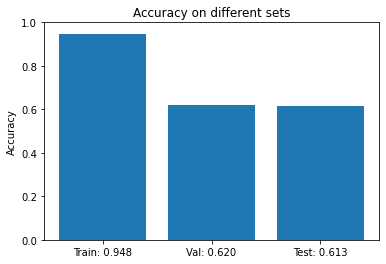

In [31]:
y_train_pred = keras_y_encoder.inverse_transform(tf_model.predict(keras_X_train))
y_train_true = keras_y_encoder.inverse_transform(keras_y_train)

y_val_pred = keras_y_encoder.inverse_transform(tf_model.predict(keras_X_val))
y_val_true = keras_y_encoder.inverse_transform(keras_y_val)

y_test_pred = keras_y_encoder.inverse_transform(tf_model.predict(keras_X_test))
y_test_true = keras_y_encoder.inverse_transform(keras_y_test)

print(report(y_test_pred, y_test_true))
plots(accuracy(y_train_pred, y_train_true), accuracy(y_test_pred, y_test_true), accuracy(y_val_pred, y_val_true))